## Importing modules

In [2]:
import numpy as np
import pydicom
import glob
import matplotlib.pyplot as plt
import cv2
from read_roi import read_roi_file
from ipywidgets import interact, IntRangeSlider
import ipyvolume as ipv
import scipy.ndimage
from plotly.figure_factory import create_trisurf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Getting dcm files

In [3]:

dir_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2AX'
files = glob.glob(dir_path + '/*.dcm')

## Reading slice

In [4]:
def rescale(im, max, min):
    return ((im.astype(float) - min) * (1. / (max - min)) * 255.).astype('uint8')


def read_slices(filename):
    name, ext = filename.split('.')

    if ext != 'dcm':
        raise ValueError('Input filename must be a DICOM file')

    slide = pydicom.dcmread(filename).pixel_array

    return slide


# ordering as istance number
z = [float(pydicom.read_file(f, force=True).get(
    "InstanceNumber", "0") - 1) for f in files]
order = np.argsort(z)
files = np.asarray(files)[order]

slice = [read_slices(f) for f in files]

Max = max([x.max() for x in slice])
Min = min([x.min() for x in slice])

slice = [rescale(x, Max, Min) for x in slice]

slice = np.asarray(slice)


### Slice info

In [ ]:

depth, height, width = slice.shape
print(
    f"The image object has the following dimensions: depth:{depth}, height: {height}, width:{width}")

# 2D Plotting

## Plotting Slice

### Random layer plot

In [ ]:


maxval = depth  # Select random layer number
i = np.random.randint(0, maxval)

print(f"Plotting Layer {i} of Image")

plt.figure(figsize=(12, 7), constrained_layout=True)
plt.imshow(slice[i, :, :], cmap='gray')
plt.axis('off')


### Interactive slice plot

In [ ]:

@interact(layer=(0, slice.shape[0] - 1))
def explore_slice(layer):
    plt.figure(figsize=(12, 7), constrained_layout=True)
    plt.imshow(slice[layer, :, :], cmap='gray')
    plt.title('Explore Layers', fontsize=20)
    plt.axis('off')

    return layer


## ROIS

### Getting ROIs

In [5]:
roi_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2ROI'
rois_list = glob.glob(roi_path + '/*.roi')

def _dict(dict_list):
    '''

    useful to get true_dict since roi is {name file : true_dict}.

    '''

    true_dict = []

    for i in dict_list:
        _dict = list(i.values())

        for j in _dict:
            keys = j.keys()
            vals = j.values()

            _dict = {key: val for key, val in zip(keys, vals)}
            true_dict.append(_dict)

    return true_dict

rois = [read_roi_file(roi) for roi in rois_list]
rois = _dict(rois)

# ordering dictionaries by positions and removing rois without x y coords
rois = sorted(rois, key=lambda d: list(d.values())[-1])
rois = list(filter(lambda d: d['type'] != 'composite', rois))

positions = []
xs = []
ys = []
for i in range(len(rois)):
    position = rois[i]['position']
    x = rois[i]['x']
    y = rois[i]['y']

    x.append(x[0])
    y.append(y[0])

    positions.append(position)
    xs.append(x)
    ys.append(y)


### Exploring ROIs

In [27]:

@interact(layer=(0, slice.shape[0] - 1))
def explore_roi(layer):
    plt.figure(figsize=(12, 7))
    plt.imshow(slice[layer, :, :], cmap='gray')
    if layer in positions:
        plt.plot(xs[layer - positions[0]], ys[layer - positions[0]], color="red",
                 linestyle='dashed', linewidth=1)
    plt.title(f'Explore Layer {layer}', fontsize=20)
    plt.axis('off')

    return layer


interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### ROIs masks

In [16]:

@interact(layer=(0, slice.shape[0] - 1))
def explore_mask(layer):

    if layer in positions:

        image = slice[layer, :, :].copy()

        pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

        cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
        cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
        mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

        fig, ax=plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True)

        ax[1].imshow(mask, cmap="gray")
        ax[1].set_title("Mask")
        ax[1].axis('off')

        ax[0].imshow(slice[layer, :, :], cmap="gray")
        ax[0].plot(xs[layer - positions[0]],ys[layer - positions[0]] , color="red",
                    linestyle='dashed', linewidth=1)
        ax[0].set_title("ROI")
        ax[0].axis('off')

        fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)

    else:
        print("no mask found in this layer")

        plt.figure(figsize=(12, 7), constrained_layout=True)
        plt.imshow(slice[layer, :, :], cmap='gray')
        plt.title(f"Exploring layer: {layer}",  fontsize=20)



interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Appling ROIs Mask

In [33]:

@interact(layer=(0, slice.shape[0] - 1))
def explore_masked_image(layer):
    
    image = slice[layer, :, :].copy()

    if layer in positions:
        pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

        cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
        cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
        mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

        masked_img = cv2.bitwise_and(slice[layer, :, :].copy(), image, mask = mask)

        fig, ax = plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True)
        ax[0].imshow(mask, cmap="gray")
        ax[0].set_title("ROI Mask")
        ax[0].axis('off')

        ax[1].imshow(masked_img, cmap="gray")
        ax[1].set_title("Applied ROI mask")
        ax[1].axis('off')
        fig.suptitle(f'Exploring layer {layer}', fontsize=20)
    else:
        print("no mask found in this layer")    

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Exploring Histogram 

In [8]:
@interact(layer=(0, slice.shape[0] - 1))
def explore_histogram(layer):

    fig, ax=plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True) 

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original image")
    ax[0].axis("off")

    ax[1].hist(slice[layer, :, :].ravel(),256,[0,256], align="right", color="black")
    ax[1].set_title("Histogram")

    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)
    plt.show()

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Manual Thresholding 

In [18]:


@interact(layer=(0, slice.shape[0] - 1), threshold=IntRangeSlider(value=[63,120], min=0, max=255, step=1, ) )
def manual_tresh(layer, threshold):

    image = slice[layer, : ,:].copy()


    t_min = threshold[0]
    t_max = threshold[1]
    

    mask = cv2.threshold(image, t_min, t_max, cv2.THRESH_BINARY_INV)[1]


    fig, ax=plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True) 


    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original image")
    ax[0].axis("off")

    ax[1].hist(slice[layer, :, :].ravel(),256,[0,256], align="right", color="black")
    ax[1].set_title("Histogram")
    ax[1].vlines(t_min,0, 10000, color="red", linestyle="dashed")
    ax[1].vlines(t_max,0, 10000, color="red", linestyle="dashed")
    ax[1].text(t_min, 10000, "$T_{min}$")
    ax[1].text(t_max, 10000, "$T_{max}$")
   


    ax[2].imshow(mask, cmap="gray")
    ax[2].set_title("Thresholded Image")
    ax[2].axis("off")



    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)

    plt.show()

interactive(children=(IntSlider(value=14, description='layer', max=29), IntRangeSlider(value=(63, 120), descri…

### Box mask

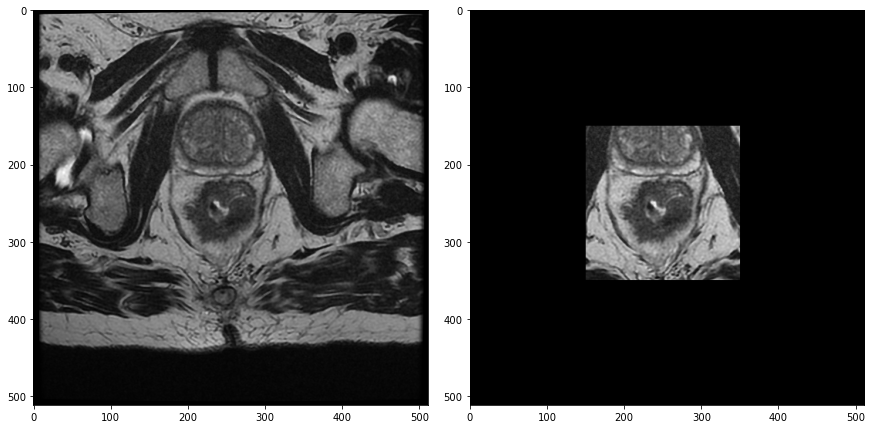

In [34]:
layer = 14

img = image = slice[layer, : ,:].copy()
mask = np.zeros(img.shape[:2], np.uint8)
mask[150:350, 150:350] = 255

masked_img = cv2.bitwise_and(img,img,mask = mask)

fig, ax = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)

ax[0].imshow(img, cmap="gray")

ax[1].imshow(masked_img, cmap="gray")

# 3D Plotting

### ipyvolume

In [ ]:

mri_vol = ipv.volshow(
    slice, lighting=True,
    data_min=0, data_max=255, stereo=True)

ipv.show()



### Resampling for making 3d mesh 

In [ ]:


def resample(image, dcmfiles, new_spacing=[1, 1, 1]):
    # Determine current pixel spacing

    slice_thick = float(pydicom.read_file(dcmfiles[0], force=True).get(
        "SliceThickness"))

    pix_space = pydicom.read_file(dcmfiles[0], force=True).get(
        "PixelSpacing")

    pix_space = [float(x) for x in pix_space]

    spacing = map(float, ([slice_thick] + pix_space))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)

    return image, new_spacing


print("Shape before resampling\t", slice.shape)
imgs_after_resamp, spacing = resample(slice, files, [1, 1, 1])
print("Shape after resampling\t", imgs_after_resamp.shape)



### 3D Mesh

In [ ]:


def make_mesh(image, step_size=1):

    print("Transposing surface")
    p = image.transpose(2, 1, 0)

    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(
        p, step_size=step_size, allow_degenerate=True)
    return verts, faces


def plotly_3d(verts, faces):
    x, y, z = zip(*verts)

    print("Drawing")

    # Make the colormap single color since the axes are positional not intensity.

    colormap = ['rgb(0, 0, 0)', 'rgb(255, 255, 255)']

    fig = create_trisurf(x=x,
                         y=y,
                         z=z,
                         plot_edges=True,
                         simplices=faces,
                         colormap=colormap,
                         title="Interactive Visualization")
    iplot(fig)



### 3D mesh plotly

In [ ]:
v, f = make_mesh(imgs_after_resamp, 2)
plotly_3d(v, f)